In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트
import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article

# 페이지 수, 카테고리, 날짜를 입력
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'출력
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
url_list = []

In [3]:
#코드 네이밍
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [4]:

#- 데이터프레임을 생성
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명
  df['code'] = idx2word[str(code)]
  return df

In [5]:
code_list = [101, 102, 103, 105]

code_list

[101, 102, 103, 105]

In [6]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [7]:
df = make_total_data(1, code_list, 20231128)

101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [8]:
#다른 일자 데이터 추가
df = df.append(make_total_data(1, code_list, 20231123))

101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [9]:

df = df.append(make_total_data(1, code_list, 20231124))

101번 코드에 대한 데이터를 만들었습니다.
102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [10]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


In [11]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,"조수미·이정재·싸이, 엑스포 PT 등장…“공존의 도시 부산에 오세요” [엑스포 개최...",경제
1,미국 9월 주택가격 8개월 연속 상승…사상 최고가 또 경신,경제
2,"횡성 ‘디피코’, 사모펀드 운용사와 조건부 투자 계약",경제
3,"10월 유로존 통화공급량 10%↓…""M3 4개월째 감소""",경제
4,통역도 이젠 실시간으로…언어의 장벽 허무는 AI,경제


In [12]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_314/3649439000.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


0      조수미이정재싸이 엑스포  등장공존의 도시 부산에 오세요 엑스포 개최지 발표
1                  미국 월 주택가격 개월 연속 상승사상 최고가 또 경신
2                     횡성 디피코 사모펀드 운용사와 조건부 투자 계약
3                            월 유로존 통화공급량  개월째 감소
4                        통역도 이젠 실시간으로언어의 장벽 허무는 
                         ...                    
235                  폴라리스쓰리디  푸드테크서 홀 자동화 솔루션 선봬
236     오늘도 사랑스럽개 코코아 사랑스러운 강아지 반려견 육성 모바일 게임 출시
237                    컨텍 아이큐에어 공기청정기 아템 엑스 선봬만원
238                  이번엔 모바일 신분증 먹통서버 점검 중 장애 발생
239                        글로벌 바이오투자 기술이전 줄고  떴다
Name: news, Length: 240, dtype: object

In [13]:
#Null 값 확인
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [14]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  221


<AxesSubplot:>

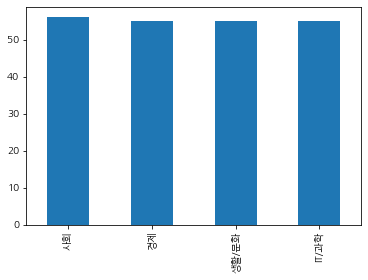

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [16]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     55
1     경제     55
2     사회     56
3  생활/문화     55


In [17]:
from konlpy.tag import Mecab

tokenizer = Mecab()

#- kor_text에 csv 파일 내용 넣기
kor_text = df['news'].to_string(index=False)

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['조수미', '이정재', '싸이', '엑스포', '등', '장공', '존', '의', '도시', '부산', '에', '오', '세요', '엑스포', '개최지', '발표', '미국', '월', '주택', '가격', '개월', '연속', '상승', '사상', '최고', '가', '또', '경신', '횡', '성', '디피', '코', '사모', '펀드', '운용', '사', '와', '조건부', '투자', '계약', '월', '유로존', '통화', '공급량', '개월', '째', '감소', '통역', '도', '이젠', '실시간', '으로', '언어', '의', '장벽', '허무', '는', '동해', '묵호항', '항만', '대기', '질', '관리', '구역', '지정', '요구', '구도심', '강릉역', '역세', '권', '개발', '은', '언제', '강릉', '부산', '철도', '내년', '개통', '기대', '이하', '속도', '속보', '엑스포', '후보', '개국', '최종', '종료', '투표', '절차', '시작', '뉴스', '초점', '부산', '엑스포', '결전', '의', '날', '최종', '로', '승부수', '오뚜기', '이', '어', '풀무원', '도', '식품', '사', '들', '가격', '인상', '철회', '함께', '나', '는', '부산갈매기', '인류', '연대', '담론', '으로', '마지막', '표', '심', '잡', '기', '종합', '농협', '은행', '판매', '중', '단홍', '콩', '지수', '폭락', '에', '손실', '우려', '내년', '회사채', '스프', '레드', '축소', '우량', '등급', '선호', '지속', '금고', '아래', '손', '넣', '으니', '돈다발', '고소득', '유', '튜버', '도', '고액', '체납자', '포함', '울산시', '아이', '가', '행복', '한', '돌봄', '도시', '년', '간', '천억', '투', '입', '

In [18]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '도',  '인', '서', '올', '와', '내일’, ‘형’, ‘로’, ‘시대’, ’곳', '과', '또', '하는', '하', '는', '속' ,'제' ,'도' ,'덜' ,'본', '부터', '전', '지역', '새', '까지', ]

In [19]:
#불용어 개수 확인
print(len(stopwords))

52


In [20]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [21]:
text_data = preprocessing(df['news'])
print(text_data[0])

조수미 이정재 싸이 엑스포 장공 존 도시 부산 오 세요 엑스포 개최지 발표


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [23]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [24]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [25]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 165
테스트용 뉴스 기사의 개수 :  56
훈련용 레이블의 개수 :  165
테스트용 레이블의 개수 :  56


In [26]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [28]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.83      0.59      0.69        17
          경제       0.60      0.33      0.43        18
          사회       0.39      0.64      0.48        11
       생활/문화       0.38      0.60      0.46        10

    accuracy                           0.52        56
   macro avg       0.55      0.54      0.52        56
weighted avg       0.59      0.52      0.52        56



# 회고

내용이 어렵다고 느껴 시작하기 전 내용을 이해하기 위해 시간을 많이 소비했는데,
이해가 되지 않았더라도 직접 실습을 늦게 시작해 시간관리가 잘 되지 못했다고 느꼈습니다.

직접 모델을 돌려보며 f1 score를 높이기 위해 노력했으나 데이터 양이 많아짐에 따라 점점 수치가 낮아지는데,
원인을 찾지 못해 아쉬움이 많은 과제였습니다.